# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


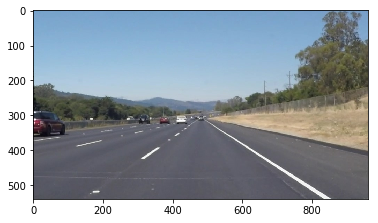

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [9]:
# Finding the left and right lane requires some helper functions.
# Here I define functions useful for finding slopes and elements of linear functions.
# These functions play a key role when we calculate the linear functions for the lane lines.

def findSlopes(array):
    '''
    Calculates the slope of both the left and right lane line.
    :param array: an array of lines found in the probabilistic Hough Transform method of OpenCV.
    :return: The slope of the left and right lane lines.
    '''
    left_lines_m = []
    right_lines_m = []
    
    for line in array:
        x1, y1, x2, y2 = line[0][0], line[0][1], line[0][2], line[0][3]
        k_line = (y2 - y1)/(x2 - x1)
        # Separate the left and right lane lines
        if k_line < 0:
            right_lines_m.extend([k_line])
        elif k_line > 0:
            left_lines_m.extend([k_line])
    
    # We'll use a modified average to better isolate the correct lines.
    # See arrayAverage()
    left_avg = arrayAverage(left_lines_m)
    m_leftLane = findNearestSlope(left_lines_m, left_avg)
    
    right_avg = arrayAverage(right_lines_m)
    m_rightLane = findNearestSlope(right_lines_m, right_avg)
    
    # Return the slopes
    return m_leftLane, m_rightLane


def arrayAverage(array):
    '''
    Calculates a modified average of an array.
    We remove the min and max values in the array 
    to remove the biggest biases and achieve better overall results.
    :param array: a list of numbers.
    :return: the array's modified average.
    '''
    sum = 0
    min = array[0]
    max = array[0]
    for m in array:
        sum += m
        if m < min:
            min = m
        if m > max:
            max = m
    return (sum-min-max)/(len(array)-2)


def findYIntercept(x1, y1, slope):
    '''
    Calculates the Y-axis intercept point of a linear function.
    :param x1: x value (coordinate)
    :param y1: y value (coordinate)
    :param slope: the slope value (as M in y=Mx+B)
    :return: the Y-Intercept point
    '''
    return y1-(slope*x1)


def findXIntercept(slope, yIntercept, ysize):
    '''
    Calculates the X-axis intercept point in an image.
    :param slope: the slope value (as M in y=Mx+B)
    :param yIntercept: the Y-axis intercept point of a linear function
    :param ysize: the y-axis size of an image.
    :return: the X-axis intercepting point at the bottom pixel line of an image.
    '''
    return -(yIntercept/(slope*ysize))


def findX(slope, yIntercept, yValue):
    '''
    Finds the X value for a given linear function.
    :param slope: the slope value (as M in y=Mx+B)
    :param yIntercept: the Y-axis intercept point of a linear function
    :param yValue: y value (coordinate for the needed x)
    :return: the x
    '''
    return (yValue - yIntercept) / slope


def findNearestSlope(array, value):
    '''
    Finds the nearest-neighbor to the given value in the array.
    Useful for finding the closest matching slope to the average slope
    of all the left/right lane lines found using the Hough Transform.
    :param array: a 1-D list, something like [0.00, 1.23, 4.96, 3.55]
    :param value: a reference value for finding our nearest-neighbor.
    :return: a list element closest to the reference value.
    '''
    n = [abs(i-value) for i in array]
    idx = n.index(min(n))
    return array[idx]


def findPointsOnLine(lines, slope):
    '''
    Detects points that are found on a given line.
    :param lines: a list of lines.
    :param slope: the slope of the given line.
    :return: a pair of points (pixels) which define the given slope.
    '''
    for line in lines:
        x1, y1, x2, y2 = line[0][0], line[0][1], line[0][2], line[0][3]
        if ((y2 - y1)/(x2 - x1)) == slope:
            return line


def findBestMatch(lines, xsize, ysize, horizon=-1):
    '''
    Finds the best line matches for the left and right lane line.
    :param lines: a list of lines found using the Hough Transform
    :param xsize: x-size of an image, ex. 1024px
    :param ysize: y-size of an image, ex. 768px
    :param horizon: a maximum height to which we draw the lines, for consistency between frames
    :return: a pair of lane lines defined by 2 points each.
    '''
    m_left, m_right = findSlopes(lines)
    
    leftLinePoints = findPointsOnLine(lines, m_left)
    rightLinePoints = findPointsOnLine(lines, m_right)
    
    b_left = findYIntercept(leftLinePoints[0][0], leftLinePoints[0][1], m_left)
    b_right = findYIntercept(rightLinePoints[0][0], rightLinePoints[0][1], m_right)
    
    # Now we have Mx+B lines at both sides of our lane.
    # Let's calculate the top and bottom points where we'll draw the line
    bottom_left_pixel_x = findX(m_left, b_left, ysize)
    bottom_right_pixel_x = findX(m_right, b_right, ysize)
    top_left_pixel_x = findX(m_left, b_left, horizon)
    top_right_pixel_x = findX(m_right, b_right, horizon)
    
    # Define the lanes. Must be cast to integers - these are pixels, after all
    right_lane = [int(bottom_right_pixel_x), ysize, int(top_right_pixel_x), int(horizon)]
    left_lane = [int(bottom_left_pixel_x), ysize, int(top_left_pixel_x), int(horizon)]
    
    return [[left_lane], [right_lane]]

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, horizon):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    # find the left and right lane parameters, then draw them!
    xsize = img.shape[1]
    ysize = img.shape[0]
    lanes_to_draw = findBestMatch(lines, xsize, ysize, horizon)
    
    # For Debugging purposes.
    # print(lanes_to_draw)
    # print(lines)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lanes_to_draw, thickness=4)
    return line_img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def showimg(img, title, type="None"):
    '''
    Shows an image on screen using pyplot.
    :param img: an image to show
    :param title: a title to present above the image
    :param type: differentiates between grayscale and color images
    '''
    if type == "gray":
        plt.imshow(img, cmap=type)
    else:
        plt.imshow(img)
    plt.title(title)    
    # plt.show()
    
    

## Test Images

In [10]:
import os
pics = os.listdir("test_images")
for i in range(0,len(pics)):
    pics[i] = "test_images/" + pics[i]

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

True

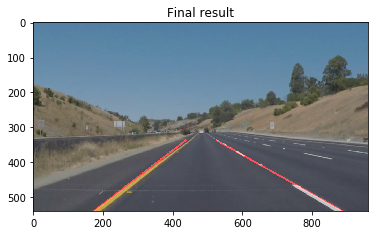

In [30]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
id=0
testimg = mpimg.imread(pics[id])
showimg(testimg, "Original image")

gray = grayscale(testimg)
showimg(gray, "Grayscale img", 'gray')
cv2.imwrite("test_images_output/" + os.listdir("test_images")[id].split('.')[0] + "_gray.jpg", gray)

gray = gaussian_blur(gray, 5)

canny_image = canny(gray, 100, 200)
# showimg(canny_image, "Canny filter", 'gray')
cv2.imwrite("test_images_output/" + os.listdir("test_images")[id].split('.')[0] + "_canny.jpg", canny_image)

xsize = testimg.shape[1]
ysize = testimg.shape[0]
 # Apply mask in a region
vertices = np.array([[(2 * xsize / 100, ysize),  # bottom left
                      ((15 * xsize) / 32, (19 * ysize) / 32),  # top left
                      ((17 * xsize) / 32, (19 * ysize) / 32),  # top right
                      (98 * xsize / 100, ysize)  # bottom right
                      ]],
                    dtype=np.int32
                    )
maskedImg = region_of_interest(canny_image, vertices)
showimg(maskedImg, "Masked region of interest", "gray")
cv2.imwrite("test_images_output/" + os.listdir("test_images")[id].split('.')[0] + "_masked.jpg", maskedImg)

houghImg = hough_lines(maskedImg, 1, np.pi/180, 6, 40, 68, (20 * ysize)/32)
showimg(houghImg, "Hough Transform", "gray")
houghImgT = cv2.cvtColor(houghImg, cv2.COLOR_BGR2RGB)
cv2.imwrite("test_images_output/" + os.listdir("test_images")[id].split('.')[0] + "_transformed.jpg", houghImgT)

finalImg = weighted_img(houghImg, testimg)
finalImgT = cv2.cvtColor(finalImg, cv2.COLOR_BGR2RGB)
showimg(finalImg, "Final result")

cv2.imwrite("test_images_output/" + os.listdir("test_images")[id].split('.')[0] + "_final.jpg", finalImgT)


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [31]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [32]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    gray = grayscale(image)
    gray = gaussian_blur(gray, 5)
    canny_image = canny(gray, 100, 250)
    
    xsize = gray.shape[1]
    ysize = gray.shape[0]
     # Apply mask in a region
    vertices = np.array([[(2 * xsize / 100, ysize),  # bottom left
                          ((15 * xsize) / 32, (19 * ysize) / 32),  # top left
                          ((17 * xsize) / 32, (19 * ysize) / 32),  # top right
                          (98 * xsize / 100, ysize)  # bottom right
                          ]],
                        dtype=np.int32
                        )
    maskedImg = region_of_interest(canny_image, vertices)
    
    houghImg = hough_lines(maskedImg, 1, np.pi/180, 10, 46, 65, (20 * ysize)/32) # 6, 40, 68
    
    result = weighted_img(houghImg, image)
    return result

Let's try the one with the solid white lane on the right first ...

In [33]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:02<00:00, 91.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.14 s, sys: 384 ms, total: 2.53 s
Wall time: 2.79 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [34]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [35]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:07<00:00, 85.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 6.9 s, sys: 1.31 s, total: 8.2 s
Wall time: 8.34 s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

** Not submitted ATM **

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))